# Paper Figures

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from htc.evaluation.metrics.scores import normalize_grouped_cm
from htc.models.data.DataSpecification import DataSpecification
from htc.settings import settings
from htc.tissue_atlas.MetricAggregationClassification import MetricAggregationClassification
from htc.tissue_atlas.settings_atlas import settings_atlas
from htc.tissue_atlas.tables import median_cam_table
from htc.utils.Config import Config
from htc.utils.helper_functions import sort_labels, sort_labels_cm
from htc.utils.sqldf import sqldf

## Confusion Matrix

In [2]:
run_dir = settings.training_dir / "median_pixel" / settings_atlas.best_run
config = Config(run_dir / "config.json")
agg = MetricAggregationClassification(run_dir / "test_table.pkl.xz", config, metrics=["accuracy", "confusion_matrix"])
df_metrics = agg.subject_metrics()

cm = np.stack(df_metrics["confusion_matrix"].values)
cm_abs = np.sum(cm, axis=0)
cm_rel, cm_rel_std = normalize_grouped_cm(cm)
cm_rel *= 100
cm_rel_std *= 100

# We need to reorder the organs according to the official "organ ordering"
original_labels = list(settings_atlas.labels)
labels = sort_labels(original_labels)
cm_abs = sort_labels_cm(cm_abs, cm_order=original_labels, target_order=labels)
cm_rel = sort_labels_cm(cm_rel, cm_order=original_labels, target_order=labels)
cm_rel_std = sort_labels_cm(cm_rel_std, cm_order=original_labels, target_order=labels)
cm_abs = cm_abs.astype(np.int64)

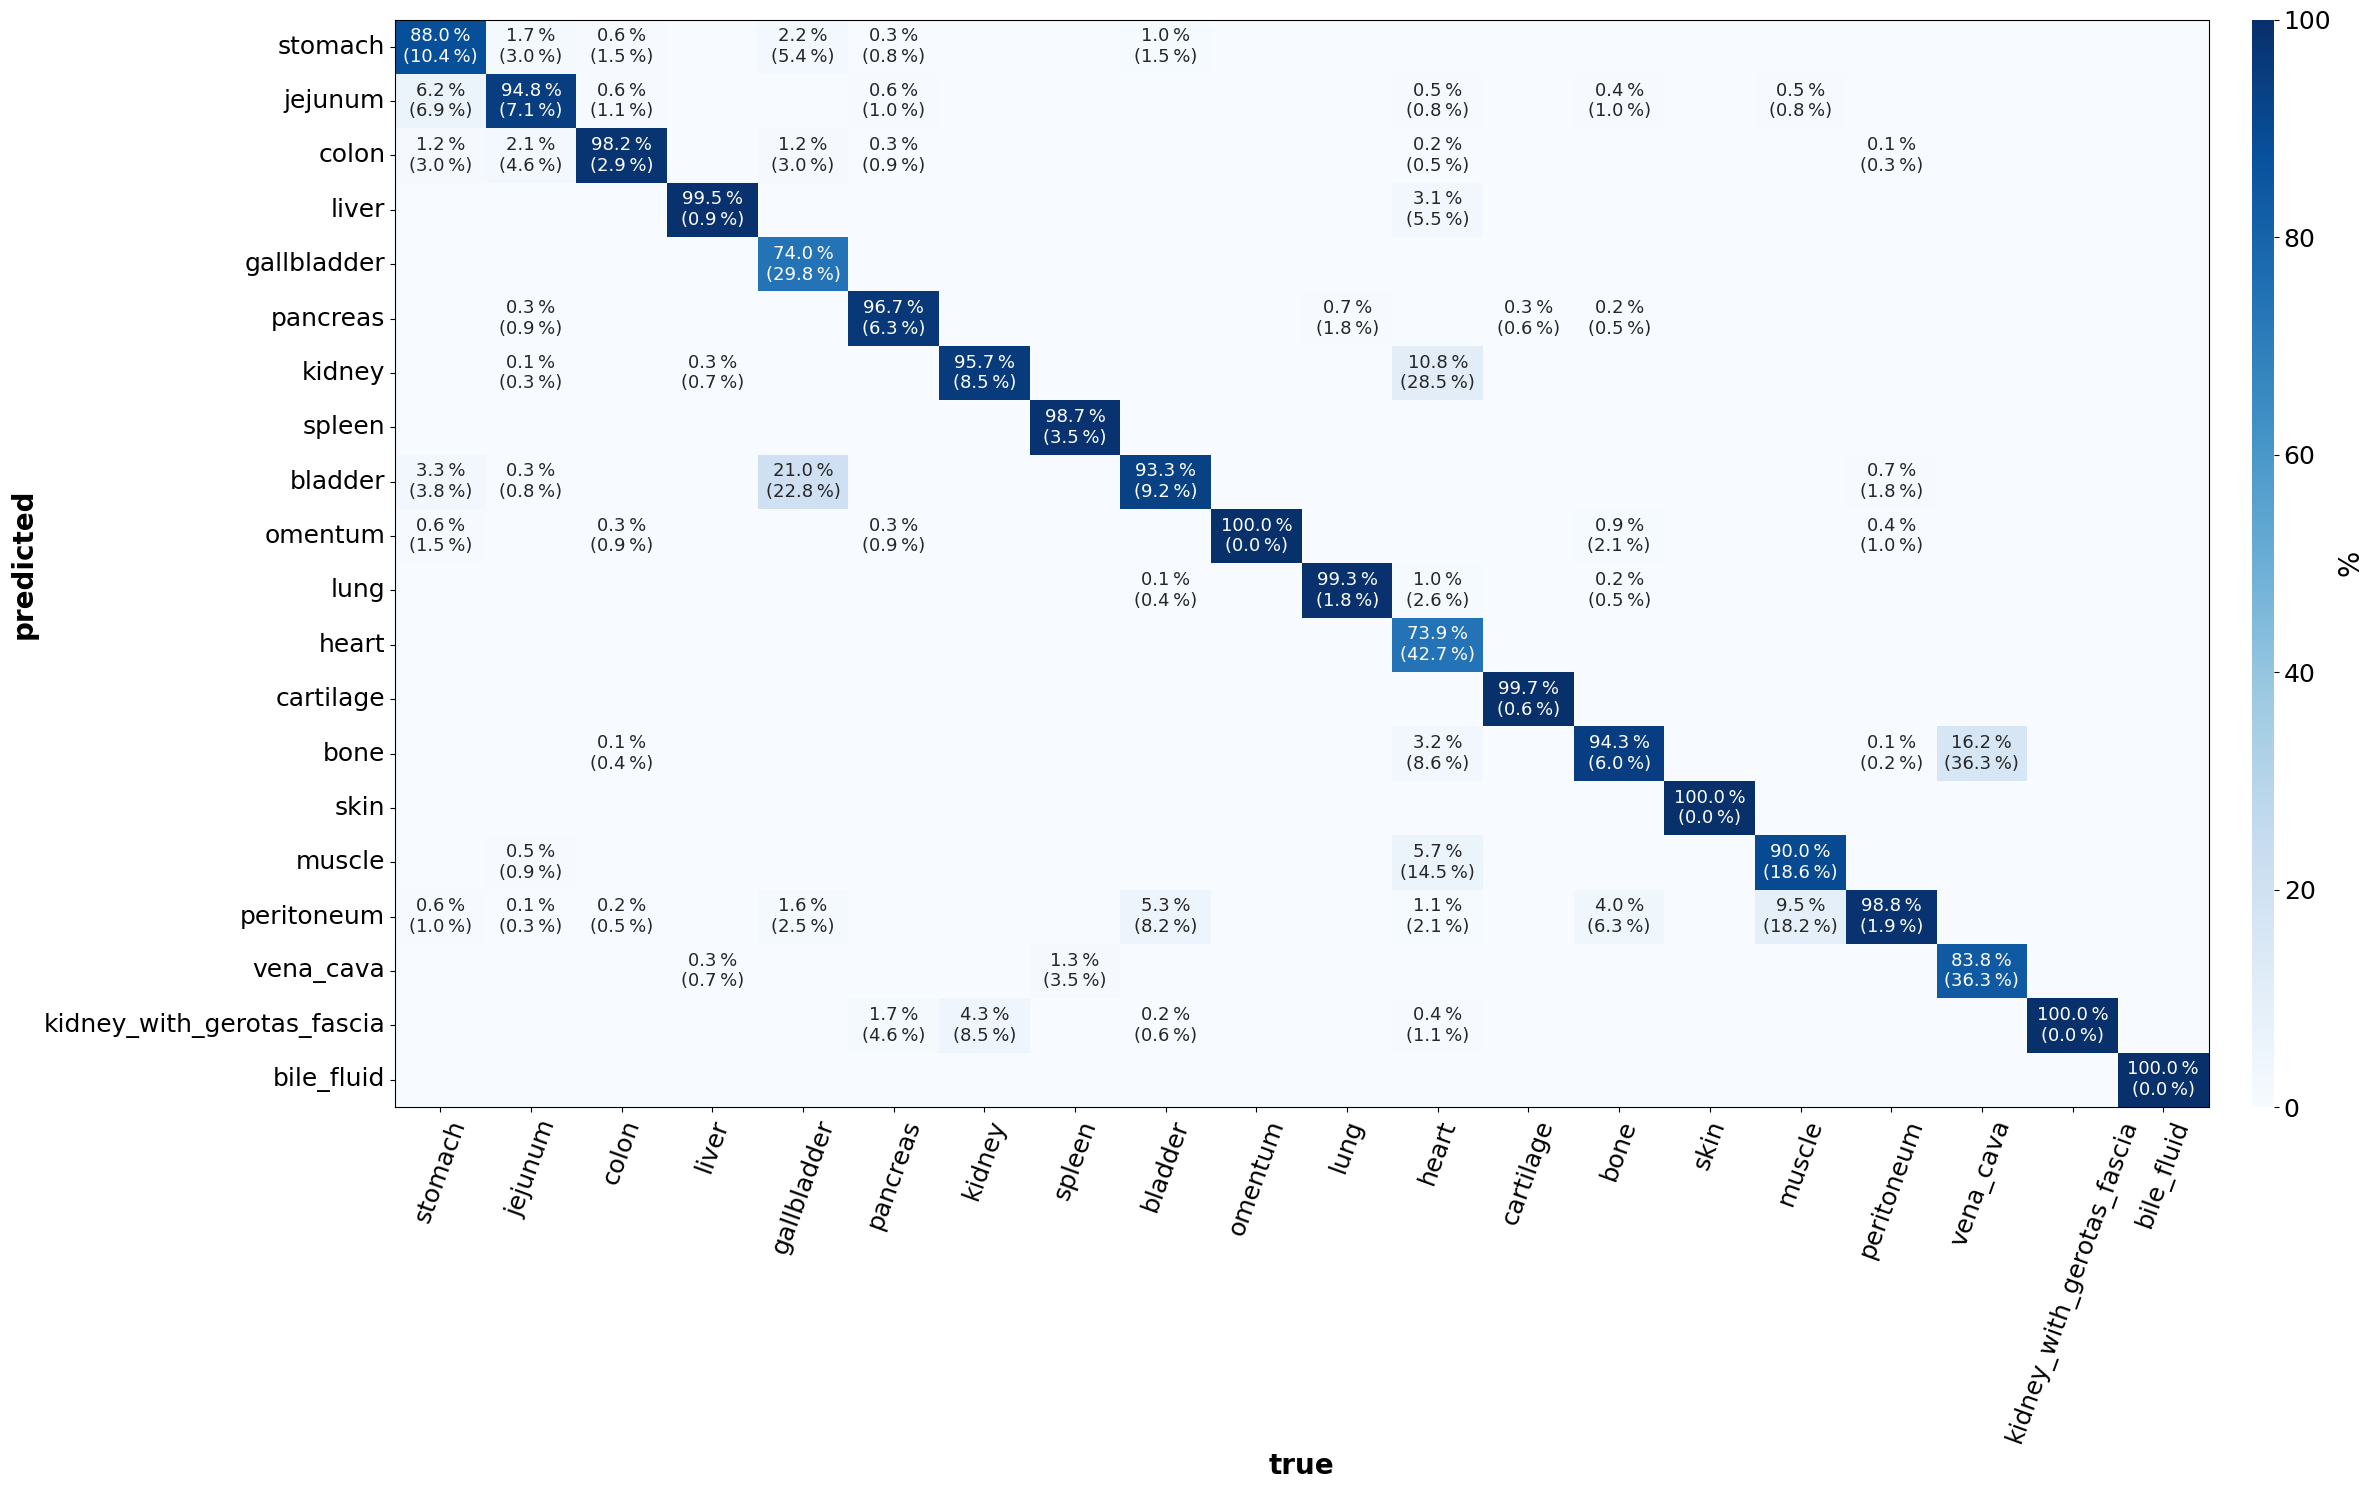

In [3]:
def get_conf_figure(cm_rel: np.ndarray, cm_abs: np.ndarray, cm_rel_std: np.ndarray) -> plt.Figure:
    # confusion matrix with relative numbers
    fig, ax = plt.subplots(tight_layout=True, figsize=(26, 15), dpi=100, edgecolor="k")
    labels_renamed = ["kidney_with_gerotas_fascia" if l == "kidney_with_Gerotas_fascia" else l for l in labels]

    text = np.vectorize(lambda x_abs, x_rel, x_rel_std: "" if x_abs == 0 else f"{x_rel:.1f} %\n({x_rel_std:.1f} %)")(
        cm_abs, cm_rel, cm_rel_std
    )
    res = sns.heatmap(
        cm_rel,
        annot=text,
        annot_kws={"size": 13},
        fmt="s",
        xticklabels=labels_renamed,
        yticklabels=labels_renamed,
        cmap="Blues",
        cbar_kws={"label": "%", "aspect": 50, "pad": 0.02},
    )

    # Make frame visible
    for _, spine in res.spines.items():
        spine.set_color("k")
        spine.set_visible(True)

    cbar_axes = ax.figure.axes[-1]
    cbar_axes.tick_params(labelsize=18)
    cbar_axes.yaxis.label.set_size(20)

    # Highlight test set
    for i, t in enumerate(ax.xaxis.get_ticklabels()):
        t.set_rotation(70)

    ax.tick_params(axis="both", labelsize=18)

    return fig


get_conf_figure(cm_rel.T, cm_abs.T, cm_rel_std.T)  # In the paper, the matrix is transposed
plt.xlabel("true", fontweight="bold", fontsize=20)
plt.ylabel("predicted", fontweight="bold", fontsize=20)
plt.savefig(settings_atlas.paper_dir / "tissue_atlas_cm.pdf")
plt.savefig(settings_atlas.paper_dir / "tissue_atlas_cm.png")

In [4]:
(round(df_metrics["accuracy"].mean(), 3), round(df_metrics["accuracy"].std(), 3))

(0.954, 0.036)

In [5]:
metrics_class = ["recall", "specificity", "f1_score"]
agg_class = MetricAggregationClassification(run_dir / "test_table.pkl.xz", config, metrics=metrics_class)
df_metric_class = agg_class.subject_metrics(average="macro")
for m in metrics_class:
    print(f"{m}: {round(df_metric_class[m].mean(), 3):.3f} ± {round(df_metric_class[m].std(), 3):.3f}")

recall: 0.930 ± 0.063
specificity: 0.998 ± 0.002
f1_score: 0.923 ± 0.065


## Data Statistics

In [6]:
used_camera_names = ["0102-00085_correct-1", "0202-00118_correct-1"]
df_stats = median_cam_table(all_cameras=True).query("camera_name in @used_camera_names")
specs = DataSpecification(settings.src_dir / "htc/tissue_atlas/data/tissue-atlas_loocv_test-8_seed-0_cam-118.json")
specs.activate_test_set()
test_pigs = {p.subject_name for p in next(iter(specs))[1]["test"]}
df_stats["is_test"] = [p in test_pigs for p in df_stats["subject_name"]]
test_pigs

{'P086', 'P087', 'P089', 'P091', 'P092', 'P093', 'P095', 'P096'}

In [7]:
sqldf(
    """
    SELECT COUNT(DISTINCT subject_name) AS n_pigs,
           COUNT(DISTINCT image_name) AS n_images,
           COUNT(DISTINCT CASE WHEN is_test = 0 THEN image_name ELSE NULL END) AS n_images_train,
           COUNT(DISTINCT CASE WHEN is_test = 1 THEN image_name ELSE NULL END) AS n_images_test
    FROM df_stats
"""
)

,n_pigs,n_images,n_images_train,n_images_test
0,46,9059,3766,5293


In [8]:
df_pigs = sqldf(
    """
    SELECT label_name,
           COUNT(DISTINCT subject_name) AS n_pigs_total,
           COUNT(DISTINCT CASE WHEN is_test = 0 THEN subject_name ELSE NULL END) AS n_pigs_train,
           COUNT(DISTINCT CASE WHEN is_test = 1 THEN subject_name ELSE NULL END) AS n_pigs_test
    FROM df_stats
    GROUP BY label_name
"""
)
df_pigs.label_name = df_pigs.label_name.astype("category")
df_pigs.label_name = df_pigs.label_name.cat.set_categories(labels)
df_pigs.sort_values(by=["label_name"], inplace=True)
df_pigs.to_csv(settings_atlas.paper_dir / "stats_pig.csv", index=False)
df_pigs

,label_name,n_pigs_total,n_pigs_train,n_pigs_test
18,stomach,39,32,7
7,small_bowel,44,36,8
4,colon,39,31,8
10,liver,41,33,8
5,gallbladder,28,21,7
14,pancreas,31,23,8
8,kidney,42,34,8
17,spleen,41,33,8
1,bladder,32,24,8
13,omentum,23,16,7


In [9]:
# ML results from the conf mat which will be added later as columns
rows = []
for i, label in enumerate(labels):
    rows.append([label, cm_abs[i, i], np.sum(cm_abs[i, :]) - cm_abs[i, i]])
df_ml = pd.DataFrame(rows, columns=["label_name", "n_annotations_correctly_classified", "n_annotations_misclassified"])
df_ml

df_annotations = sqldf(
    """
    SELECT label_name,
           COUNT(*) AS n_annotations_total,
           COUNT(CASE WHEN is_test = 0 THEN 1 ELSE NULL END) AS n_annotations_train,
           COUNT(CASE WHEN is_test = 1 THEN 1 ELSE NULL END) AS n_annotations_test
    FROM df_stats
    GROUP BY label_name
"""
)
df_annotations = df_annotations.merge(df_ml, "left", on="label_name")
df_annotations["label_name"] = df_annotations["label_name"].astype("category")
df_annotations["label_name"] = df_annotations["label_name"].cat.set_categories(labels)
df_annotations.sort_values(by=["label_name"], inplace=True)
df_annotations.to_csv(settings_atlas.paper_dir / "stats_annotations.csv", index=False)
df_annotations

,label_name,n_annotations_total,n_annotations_train,n_annotations_test,n_annotations_correctly_classified,n_annotations_misclassified
18,stomach,849,396,453,394,59
7,small_bowel,1546,783,763,721,42
4,colon,1330,669,661,649,12
10,liver,1454,721,733,729,4
5,gallbladder,526,236,290,208,82
14,pancreas,530,253,277,267,10
8,kidney,568,277,291,276,15
17,spleen,1353,692,661,651,10
1,bladder,779,358,421,384,37
13,omentum,570,263,307,307,0


In [10]:
df_annotations["n_annotations_total"].sum()

17777